# **Bibliotecas**

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 29.2 MB/s eta 0:00:00


In [2]:
import urllib.request
import os
import zipfile
import pandas as pd

import glob
from tqdm.auto import tqdm
tqdm.pandas()
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil

import numpy as np
from skimage.transform import resize

import optuna

# **Base de dados (placas de trânsito)**

In [3]:
# URL para o conjunto de dados
url = ("https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip")

# Verifica se o arquivo já existe para evitar baixar novamente
if not os.path.exists("GTSRB_Final_Training_Images.zip"):
    # Define o nome do arquivo
    filename = "./GTSRB_Final_Training_Images.zip"
    # Baixa o arquivo da URL e salva com o nome definido
    urllib.request.urlretrieve(url, filename)

#Extraindo arquivos

# Caminho do arquivo zip
zip_path = 'GTSRB_Final_Training_Images.zip'

# Pasta onde os arquivos serão extraídos
extract_to = 'GTSRB_Final_Training_Images/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Arquivos extraídos para: {extract_to}")

Arquivos extraídos para: GTSRB_Final_Training_Images/


In [4]:
# Lista para armazenar os caminhos completos de todos os arquivos CSV encontrados
csv_files = []

# Percorrer a pasta principal e suas subpastas
for root, dirs, files in os.walk(extract_to):
    # Filtrar apenas os arquivos .csv em cada pasta
    for file in files:
        if file.endswith('.csv'):
            # Adicionar o caminho completo do arquivo à lista
            csv_files.append(os.path.join(root, file))

dfs = []

# Ler cada arquivo CSV e adicionar a um dataframe na lista
for arquivo in csv_files:
    df = pd.read_csv(arquivo, sep=";")  # ajuste o sep se necessário
    df['Path'] = '/'.join(arquivo.split('/')[:-1]) + '/' + df.Filename
    dfs.append(df)

# Concatenar todos os dataframes em um único dataframe final
df_final = pd.concat(dfs, ignore_index=True)

# Imprimir o formato do dataframe final e as primeiras linhas
print(df_final.shape)
df_final.head()

(39209, 9)


Filename  Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0  00000_00000.ppm     26      27       6       6      21      21       36   
1  00000_00001.ppm     29      27       6       5      23      22       36   
2  00000_00002.ppm     28      29       5       6      23      24       36   
3  00000_00003.ppm     31      31       5       6      25      26       36   
4  00000_00004.ppm     33      33       5       5      27      28       36   

                                                Path  
0  GTSRB_Final_Training_Images/GTSRB/Final_Traini...  
1  GTSRB_Final_Training_Images/GTSRB/Final_Traini...  
2  GTSRB_Final_Training_Images/GTSRB/Final_Traini...  
3  GTSRB_Final_Training_Images/GTSRB/Final_Traini...  
4  GTSRB_Final_Training_Images/GTSRB/Final_Traini...

In [5]:
classes = {
    0: "Speed limit (20km/h)",
    1: "Speed limit (30km/h)",
    2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)",
    4: "Speed limit (70km/h)",
    5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)",
    7: "Speed limit (100km/h)",
    8: "Speed limit (120km/h)",
    9: "No passing",
    10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at the next intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve to the left",
    20: "Dangerous curve to the right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End of all speed and passing limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout mandatory",
    41: "End of no passing",
    42: "End of no passing by vehicles over 3.5 metric tons"
}



In [6]:
df_final['ClassName'] = df_final['ClassId'].map(classes)

In [7]:
img_size = 32
def load_img(img_file):
  try:
    img = Image.open('./'+img_file).convert('RGB')
    img = np.array(img, dtype=np.uint8)

    img = resize(
        img,
        output_shape=(img_size, img_size, 3),
        mode='reflect',
        anti_aliasing=True,
        preserve_range=False  # -> output in [0,1]
    )

    img = (img * 255).astype(np.uint8)
    return img
  except:
    return None


In [8]:
df_final['Image'] = df_final.progress_apply(lambda x: load_img(x['Path']), axis=1)

df_final = df_final.dropna(subset=['Image']).reset_index(drop=True)

  0%|          | 0/39209 [00:00<?, ?it/s]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_final.Image,
                                                    df_final.ClassName,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=df_final.ClassName
                                                    )

In [10]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Converte os dados para tensores PyTorch e normaliza para o intervalo [-1, 1]
tensor_x_treino = torch.from_numpy(np.array(list(X_train), dtype=np.uint8)).permute(0, 3, 1, 2).to(torch.float32) / 255.0
tensor_x_teste  = torch.from_numpy(np.array(list(X_test), dtype=np.uint8)).permute(0, 3, 1, 2).to(torch.float32) / 255.0

# Normalização para o intervalo [-1, 1]
tensor_x_treino = (tensor_x_treino - 0.5) / 0.5
tensor_x_teste  = (tensor_x_teste  - 0.5) / 0.5

# Converte os rótulos para tensores PyTorch (tipo long para classificação)
# Mapear os nomes das classes para IDs numéricos
class_to_id = {name: id for id, name in classes.items()}
tensor_y_treino = torch.from_numpy(np.array([class_to_id[label] for label in y_train])).to(torch.long)
tensor_y_teste = torch.from_numpy(np.array([class_to_id[label] for label in y_test])).to(torch.long)


# Cria os TensorDatasets
dataset_treino = TensorDataset(tensor_x_treino, tensor_y_treino)
dataset_teste = TensorDataset(tensor_x_teste, tensor_y_teste)

# Cria os DataLoaders
# trainloader = DataLoader(dataset_treino, batch_size=64, shuffle=True, num_workers=2)
# testloader  = DataLoader(dataset_teste, batch_size=64, shuffle=False, num_workers=2)

print("TensorDatasets criados com sucesso!")

TensorDatasets criados com sucesso!


torch.float32


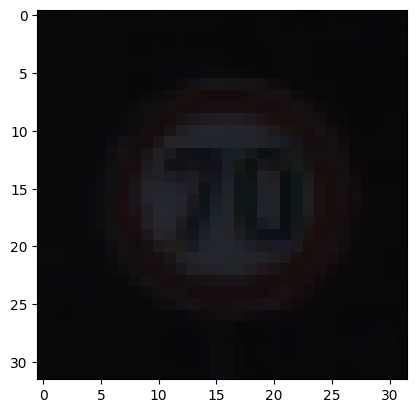

In [11]:
import matplotlib.pyplot as plt

image, label = dataset_treino[0] # Usar dataset_treino para pegar um exemplo

# Denormalize the image data from [-1, 1] to [0, 1] for plotting
image_denormalized = (image * 0.5) + 0.5

plt.imshow(image_denormalized.permute(1, 2, 0)) # Ajusta a ordem dos canais para (altura, largura, canais) para matplotlib
print(image.dtype)

# **Modelo**

In [12]:
# ===== Célula 1: Imports, configs e utilitários =====
import os, random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, TensorDataset

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score

# Reprodutibilidade
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED); random.seed(RANDOM_SEED); torch.manual_seed(RANDOM_SEED)

# Dispositivo
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# Saídas
OUT_DIR = "./resultados_mlp_optuna"
os.makedirs(OUT_DIR, exist_ok=True)
METRICS_CSV = os.path.join(OUT_DIR, "todas_metricas_por_epoca.csv")
TRIALS_CSV  = os.path.join(OUT_DIR, "resumo_trials.csv")
BEST_MODEL  = os.path.join(OUT_DIR, "best_model_state_dict.pt")

# Número de classes e dimensão de entrada (imagens 3x32x32 do seu pipeline)
N_CLASSES = 43          # len(classes)
INPUT_DIM = 3 * 32 * 32 # Flatten (C*H*W)

DEVICE: cuda


In [13]:
# ===== Célula 2: Criação do conjunto de validação =====
# Parte do pressuposto de que você já tem: dataset_treino e dataset_teste (TensorDataset)
# e DataLoaders trainloader / testloader criados nas células anteriores do seu notebook.

# Vamos criar train/val a partir do dataset_treino (80/20):
val_ratio = 0.2

# Cria um TensorDataset com dados de treino e rótulos
full_train_dataset = TensorDataset(tensor_x_treino, tensor_y_treino)

n_total = len(full_train_dataset)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val

# Divide o dataset completo de treino em treino e validação
train_ds, val_ds = random_split(full_train_dataset, [n_train, n_val],
                                generator=torch.Generator().manual_seed(RANDOM_SEED))

# DataLoaders (mantendo batch e workers semelhantes aos seus)
BATCH_SIZE_DEFAULT = 64

pin = torch.cuda.is_available()

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE_DEFAULT, shuffle=True,
    num_workers=0, pin_memory=pin, persistent_workers=False
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE_DEFAULT, shuffle=False,
    num_workers=0, pin_memory=pin, persistent_workers=False
)
test_loader = DataLoader(
    dataset_teste, batch_size=BATCH_SIZE_DEFAULT, shuffle=False,
    num_workers=0, pin_memory=pin, persistent_workers=False
)

len(train_ds), len(val_ds), len(dataset_teste)

len(train_ds), len(val_ds), len(dataset_teste)

(21957, 5489, 11763)

In [14]:
# ===== CNN: construtor com nn.Sequential =====
import torch.nn as nn

def _conv_block(in_ch, out_ch, k=3, use_bn=True):
    pad = k // 2  # padding 'same' para k ímpar
    layers = [nn.Conv2d(in_ch, out_ch, kernel_size=k, padding=pad, bias=not use_bn)]
    if use_bn:
        layers.append(nn.BatchNorm2d(out_ch))
    layers.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layers)

def build_cnn_sequential(
    in_channels=3,
    num_classes=43,
    n_blocks=2,              # 2 ou 3 blocos conv
    ch1=32, ch2=64, ch3=128, # canais por bloco
    kernel_size=3,           # 3 ou 5
    use_bn=True,
    dropout_p=0.3,
    fc_units=256             # tamanho da FC intermediária
) -> nn.Sequential:
    """
    CNN simples:
      [Conv-BN-ReLU]x1 -> MaxPool(2)
      [Conv-BN-ReLU]x1 -> MaxPool(2)
      (opcional) terceiro bloco -> MaxPool(2)
      Flatten -> Dropout -> Linear -> ReLU -> Dropout -> Linear(num_classes)
    Entradas: (N, 3, 32, 32); com 2 pools -> feature map 8x8; com 3 pools -> 4x4
    """
    feats = []
    c_in = in_channels
    chs = [ch1, ch2] + ([ch3] if n_blocks == 3 else [])
    pools = 0
    for i, c_out in enumerate(chs):
        feats.append(_conv_block(c_in, c_out, k=kernel_size, use_bn=use_bn))
        feats.append(nn.MaxPool2d(kernel_size=2, stride=2))
        c_in = c_out
        pools += 1

    # calcula spatial após pooling: 32 -> 16 -> 8 -> 4 ...
    spatial = 32 // (2 ** pools)  # 2 blocos -> 8; 3 blocos -> 4
    feat_dim = c_in * spatial * spatial

    classifier = [
        nn.Flatten(),
        nn.Dropout(dropout_p),
        nn.Linear(feat_dim, fc_units),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_p),
        nn.Linear(fc_units, num_classes),
    ]

    model = nn.Sequential(*(feats + classifier)).to(DEVICE)
    return model


In [15]:
# ===== Célula 4: Funções de treino/val/test =====
def train_one_epoch(model, loader, optimizer, criterion):
    """
    Treina 1 época:
    - Retorna (loss_médio, acc)
    """
    model.train()
    losses, preds_all, y_all = [], [], []
    pbar = tqdm(loader, desc="Treinando", leave=False)
    for xb, yb in pbar:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        preds = torch.argmax(logits, 1)
        preds_all.append(preds.detach().cpu().numpy())
        y_all.append(yb.detach().cpu().numpy())
        pbar.set_postfix(loss=np.mean(losses))

    preds_all = np.concatenate(preds_all); y_all = np.concatenate(y_all)
    acc = accuracy_score(y_all, preds_all)
    return float(np.mean(losses)), float(acc)


@torch.no_grad()
def evaluate(model, loader, criterion):
    """
    Avaliação:
    - Retorna (loss_médio, acc)
    """
    model.eval()
    losses, preds_all, y_all = [], [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss = criterion(logits, yb)
        losses.append(loss.item())
        preds = torch.argmax(logits, 1)
        preds_all.append(preds.detach().cpu().numpy())
        y_all.append(yb.detach().cpu().numpy())

    preds_all = np.concatenate(preds_all); y_all = np.concatenate(y_all)
    acc = accuracy_score(y_all, preds_all)
    return float(np.mean(losses)), float(acc)

In [16]:
# ===== Célula 5: Execução de um treino completo com logging =====
def run_training_cnn(params:dict,
                     train_loader, val_loader, test_loader,
                     n_classes:int,
                     n_epochs:int,
                     trial_id=None):
    """
    Treina a CNN com os hiperparâmetros em 'params' e registra histórico por época.
    Espera em params:
      - n_blocks (2..3)
      - ch1, ch2, (ch3)
      - kernel_size (3|5)
      - use_bn (bool)
      - dropout_p (0..0.6)
      - fc_units (64..512)
      - lr (1e-4..3e-2)
    """
    lr       = params.get("lr", 1e-3)
    n_blocks = params["n_blocks"]
    ch1      = params["ch1"]
    ch2      = params["ch2"]
    ch3      = params.get("ch3", 128)
    k        = params["kernel_size"]
    use_bn   = params["use_bn"]
    drop     = params["dropout_p"]
    fc_units = params["fc_units"]

    model = build_cnn_sequential(
        in_channels=3, num_classes=n_classes,
        n_blocks=n_blocks, ch1=ch1, ch2=ch2, ch3=ch3,
        kernel_size=k, use_bn=use_bn, dropout_p=drop, fc_units=fc_units
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = []
    best_val_acc, best_state = -1.0, None

    for epoch in tqdm(range(1, n_epochs+1), desc=f"Trial {trial_id} | Épocas", leave=False):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        va_loss, va_acc = evaluate(model, val_loader, criterion)

        history.append({
            "trial_id": trial_id,
            "epoch": epoch,
            "train_loss": tr_loss,
            "train_acc": tr_acc,
            "val_loss": va_loss,
            "val_acc": va_acc,
            **params,
        })

        if va_acc > best_val_acc:
            best_val_acc = va_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    # Avalia no teste com melhor estado
    if best_state is not None:
        model.load_state_dict(best_state)
    te_loss, te_acc = evaluate(model, test_loader, criterion)

    return {
        "history": history,
        "best_val_acc": best_val_acc,
        "test_loss": te_loss,
        "test_acc": te_acc,
        "best_state": best_state,
    }

In [17]:
# ===== Optuna: espaço de busca para CNN =====
def suggest_params_optuna_cnn(trial):
    n_blocks = trial.suggest_int("n_blocks", 2, 3)

    ch1 = trial.suggest_categorical("ch1", [32, 48, 64])
    ch2 = trial.suggest_categorical("ch2", [64, 96, 128])

    params = {
        "n_blocks": n_blocks,
        "ch1": ch1,
        "ch2": ch2,
        "kernel_size": trial.suggest_categorical("kernel_size", [3, 5]),
        "use_bn": trial.suggest_categorical("use_bn", [True, False]),
        "dropout_p": trial.suggest_float("dropout_p", 0.0, 0.6),
        "fc_units": trial.suggest_categorical("fc_units", [128, 256, 384, 512]),
        "lr": trial.suggest_float("lr", 1e-4, 3e-2, log=True),
    }

    if n_blocks == 3:
        params["ch3"] = trial.suggest_categorical("ch3", [96, 128, 160])

    return params

def random_params_fallback():
    """Fallback simples caso Optuna não esteja disponível."""
    n_layers = random.randint(1, 4)
    hidden = [int(2 ** random.randint(5, 9)) for _ in range(n_layers)]  # 32..512
    return {
        "hidden_sizes": hidden,
        "activation": random.choice(["relu", "sigmoid"]),
        "dropout_p": random.uniform(0.0, 0.5),
        "lr": 10 ** random.uniform(-4, -1.5),
        "batch_size": random.choice([64, 128, 256]),
    }

In [32]:
# ===== Célula 7: Execução da busca, CSVs e melhor modelo =====
def run_hparam_search_cnn(n_trials=10, n_epochs=25, output_prefix="cnn_"):
    all_hist = []
    trials_rows = []

    metrics_csv_path = os.path.join(OUT_DIR, f"{output_prefix}todas_metricas_por_epoca.csv")
    trials_csv_path  = os.path.join(OUT_DIR, f"{output_prefix}resumo_trials.csv")
    best_model_path  = os.path.join(OUT_DIR, f"{output_prefix}best_model_state_dict.pt")

    print("Optuna encontrado. Iniciando estudo (CNN)...")
    def objective(trial):
        params = suggest_params_optuna_cnn(trial)
        res = run_training_cnn(
            params, train_loader, val_loader, test_loader,
            n_classes=N_CLASSES, n_epochs=n_epochs, trial_id=trial.number
        )
        all_hist.extend(res["history"])

        # Find the best validation epoch from the history of this trial
        best_epoch_data = max(res["history"], key=lambda x: x["val_acc"])

        trials_rows.append({
            "trial_id": trial.number, **params,
            "train_acc": best_epoch_data["train_acc"],
            "val_acc": best_epoch_data["val_acc"],
            "test_acc": res["test_acc"],
            "train_loss": best_epoch_data["train_loss"],
            "val_loss": best_epoch_data["val_loss"],
            "test_loss": res["test_loss"],
            "best_val_acc": res["best_val_acc"],
        })
        return res["best_val_acc"]

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    best_trial = study.best_trial

    # Reconstroi params do melhor trial
    best_params = {**best_trial.params}
    # defaults que não vieram do trial:
    if "ch3" not in best_params and best_params["n_blocks"] == 3:
        best_params["ch3"] = 128  # fallback
    # salva também hiperparâmetros fixos
    best_params.setdefault("fc_units", 256)
    best_params.setdefault("dropout_p", 0.3)
    best_params.setdefault("use_bn", True)
    best_params.setdefault("lr", 1e-3)


    print(f"Melhor trial #{best_trial.number} | best_val_acc={study.best_value:.4f}")

    # Salva CSVs
    pd.DataFrame(all_hist).to_csv(metrics_csv_path, index=False)
    trials_df = pd.DataFrame(trials_rows).sort_values("best_val_acc", ascending=False)
    trials_df.to_csv(trials_csv_path, index=False)

    # Re-treina o melhor para salvar modelo e gerar curvas
    print("Treinando melhor configuração (CNN) para salvar modelo/curvas...")
    best_run = run_training_cnn(
        best_params, train_loader, val_loader, test_loader,
        n_classes=N_CLASSES, n_epochs=n_epochs, trial_id=9999
    )
    torch.save(best_run["best_state"], best_model_path)
    return trials_df, pd.DataFrame(best_run["history"]), best_model_path

# Execute (ajuste n_trials/n_epochs conforme tempo)
trials_df, best_hist_df, best_model_path = run_hparam_search_cnn(n_trials=16, n_epochs=40, output_prefix="experimento_cnn_")
trials_df.head()

[I 2025-10-16 12:15:28,763] A new study created in memory with name: no-name-06c702d9-d3c8-4bab-b8a1-9799a20b40ef


Optuna encontrado. Iniciando estudo (CNN)...


  0%|          | 0/16 [00:00<?, ?it/s]

Trial 0 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

[I 2025-10-16 12:16:57,262] Trial 0 finished with value: 0.9881581344507196 and parameters: {'n_blocks': 2, 'ch1': 48, 'ch2': 96, 'kernel_size': 3, 'use_bn': False, 'dropout_p': 0.06993893953153471, 'fc_units': 384, 'lr': 0.00010222622601157172}. Best is trial 0 with value: 0.9881581344507196.


Trial 1 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

[I 2025-10-16 12:19:07,728] Trial 1 finished with value: 0.9954454363271998 and parameters: {'n_blocks': 2, 'ch1': 48, 'ch2': 128, 'kernel_size': 5, 'use_bn': True, 'dropout_p': 0.3896267902031065, 'fc_units': 512, 'lr': 0.00018529250699229546}. Best is trial 1 with value: 0.9954454363271998.


Trial 2 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

[I 2025-10-16 12:20:56,547] Trial 2 finished with value: 0.997631626890144 and parameters: {'n_blocks': 3, 'ch1': 64, 'ch2': 128, 'kernel_size': 3, 'use_bn': True, 'dropout_p': 0.5389506739754447, 'fc_units': 128, 'lr': 0.00021070941516880253, 'ch3': 128}. Best is trial 2 with value: 0.997631626890144.


Trial 3 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

[I 2025-10-16 12:22:33,543] Trial 3 finished with value: 0.9936236108580798 and parameters: {'n_blocks': 3, 'ch1': 64, 'ch2': 96, 'kernel_size': 3, 'use_bn': False, 'dropout_p': 0.27772018492681555, 'fc_units': 512, 'lr': 0.00015441980094162657, 'ch3': 96}. Best is trial 2 with value: 0.997631626890144.


Trial 4 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

[I 2025-10-16 12:24:01,734] Trial 4 finished with value: 0.9916196028420478 and parameters: {'n_blocks': 3, 'ch1': 32, 'ch2': 96, 'kernel_size': 3, 'use_bn': False, 'dropout_p': 0.16946238015837603, 'fc_units': 384, 'lr': 0.00014060321225272765, 'ch3': 96}. Best is trial 2 with value: 0.997631626890144.


Trial 5 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

[I 2025-10-16 12:25:52,297] Trial 5 finished with value: 0.9938057934049918 and parameters: {'n_blocks': 2, 'ch1': 48, 'ch2': 128, 'kernel_size': 3, 'use_bn': False, 'dropout_p': 0.012752600415878357, 'fc_units': 512, 'lr': 0.00041679432892949655}. Best is trial 2 with value: 0.997631626890144.


Trial 6 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

[I 2025-10-16 12:27:44,685] Trial 6 finished with value: 0.053926033885953725 and parameters: {'n_blocks': 2, 'ch1': 64, 'ch2': 64, 'kernel_size': 5, 'use_bn': True, 'dropout_p': 0.17749220191083037, 'fc_units': 384, 'lr': 0.01850343212823392}. Best is trial 2 with value: 0.997631626890144.


Trial 7 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

[I 2025-10-16 12:29:54,056] Trial 7 finished with value: 0.9959919839679359 and parameters: {'n_blocks': 2, 'ch1': 64, 'ch2': 64, 'kernel_size': 5, 'use_bn': True, 'dropout_p': 0.5603358057037395, 'fc_units': 512, 'lr': 0.0001976920814029873}. Best is trial 2 with value: 0.997631626890144.


Trial 8 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

[I 2025-10-16 12:31:44,933] Trial 8 finished with value: 0.9970850792494079 and parameters: {'n_blocks': 3, 'ch1': 64, 'ch2': 64, 'kernel_size': 3, 'use_bn': True, 'dropout_p': 0.18753923573468903, 'fc_units': 384, 'lr': 0.0008663353045279497, 'ch3': 128}. Best is trial 2 with value: 0.997631626890144.


Trial 9 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

[I 2025-10-16 12:34:15,411] Trial 9 finished with value: 0.9970850792494079 and parameters: {'n_blocks': 3, 'ch1': 64, 'ch2': 64, 'kernel_size': 5, 'use_bn': True, 'dropout_p': 0.410638031486177, 'fc_units': 512, 'lr': 0.0024402376114848103, 'ch3': 128}. Best is trial 2 with value: 0.997631626890144.


Trial 10 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

[I 2025-10-16 12:36:01,874] Trial 10 finished with value: 0.9972672617963199 and parameters: {'n_blocks': 3, 'ch1': 32, 'ch2': 128, 'kernel_size': 3, 'use_bn': True, 'dropout_p': 0.5467325842619005, 'fc_units': 128, 'lr': 0.0031206240314395665, 'ch3': 160}. Best is trial 2 with value: 0.997631626890144.


Trial 11 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

[I 2025-10-16 12:37:47,360] Trial 11 finished with value: 0.9959919839679359 and parameters: {'n_blocks': 3, 'ch1': 32, 'ch2': 128, 'kernel_size': 3, 'use_bn': True, 'dropout_p': 0.5968192393044702, 'fc_units': 128, 'lr': 0.00423219208193588, 'ch3': 160}. Best is trial 2 with value: 0.997631626890144.


Trial 12 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

[I 2025-10-16 12:39:32,315] Trial 12 finished with value: 0.9808708325742393 and parameters: {'n_blocks': 3, 'ch1': 32, 'ch2': 128, 'kernel_size': 3, 'use_bn': True, 'dropout_p': 0.4856428268487038, 'fc_units': 128, 'lr': 0.008562029277834964, 'ch3': 160}. Best is trial 2 with value: 0.997631626890144.


Trial 13 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

[I 2025-10-16 12:41:21,506] Trial 13 finished with value: 0.998724722171616 and parameters: {'n_blocks': 3, 'ch1': 32, 'ch2': 128, 'kernel_size': 3, 'use_bn': True, 'dropout_p': 0.4854950142036486, 'fc_units': 128, 'lr': 0.001044015785948095, 'ch3': 128}. Best is trial 13 with value: 0.998724722171616.


Trial 14 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

[I 2025-10-16 12:43:12,143] Trial 14 finished with value: 0.9979959919839679 and parameters: {'n_blocks': 3, 'ch1': 32, 'ch2': 128, 'kernel_size': 3, 'use_bn': True, 'dropout_p': 0.44065406993522793, 'fc_units': 256, 'lr': 0.0009667635751277189, 'ch3': 128}. Best is trial 13 with value: 0.998724722171616.


Trial 15 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

[I 2025-10-16 12:45:02,767] Trial 15 finished with value: 0.9983603570777919 and parameters: {'n_blocks': 3, 'ch1': 32, 'ch2': 128, 'kernel_size': 3, 'use_bn': True, 'dropout_p': 0.3975008869692548, 'fc_units': 256, 'lr': 0.0009589925923679959, 'ch3': 128}. Best is trial 13 with value: 0.998724722171616.
Melhor trial #13 | best_val_acc=0.9987
Treinando melhor configuração (CNN) para salvar modelo/curvas...


Trial 9999 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

trial_id  n_blocks  ch1  ch2  kernel_size  use_bn  dropout_p  fc_units  \
13        13         3   32  128            3    True   0.485495       128   
15        15         3   32  128            3    True   0.397501       256   
14        14         3   32  128            3    True   0.440654       256   
2          2         3   64  128            3    True   0.538951       128   
10        10         3   32  128            3    True   0.546733       128   

          lr  train_acc   val_acc  test_acc  train_loss  val_loss  test_loss  \
13  0.001044   0.990254  0.998725  0.998130    0.031122  0.010552   0.009264   
15  0.000959   0.996539  0.998360  0.997535    0.010403  0.008610   0.010719   
14  0.000967   0.995400  0.997996  0.997960    0.015061  0.011862   0.010026   
2   0.000211   0.986883  0.997632  0.997790    0.038284  0.009955   0.009443   
10  0.003121   0.976500  0.997267  0.995494    0.075175  0.012277   0.014072   

    best_val_acc    ch3  
13      0.998725  128.0  
15      0.998360  128.0  
14      0.997996  128.0  
2       0.997632  128.0  
10      0.997267  160.0

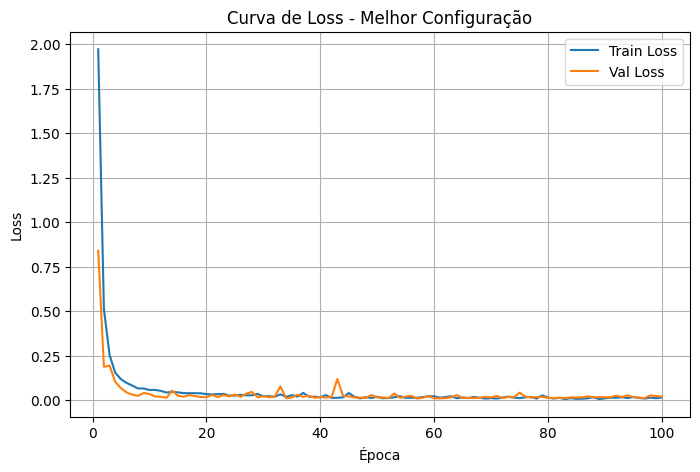

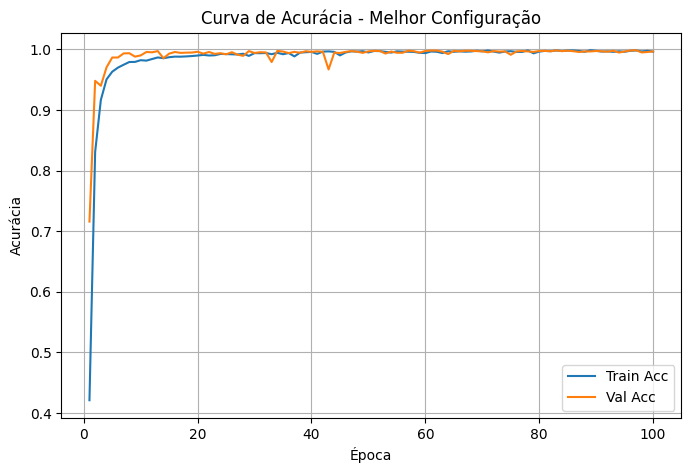

Arquivos salvos em: /content/resultados_mlp_optuna
 - Métricas por época: ./resultados_mlp_optuna/experimento_cnn_todas_metricas_por_epoca.csv
 - Resumo dos trials:  ./resultados_mlp_optuna/experimento_cnn_resumo_trials.csv
 - Melhor modelo:      ./resultados_mlp_optuna/experimento_cnn_best_model_state_dict.pt


In [31]:
# ===== Célula 8: Visualizações e caminhos dos arquivos =====
plt.figure(figsize=(8,5))
plt.plot(best_hist_df["epoch"], best_hist_df["train_loss"], label="Train Loss")
plt.plot(best_hist_df["epoch"], best_hist_df["val_loss"],   label="Val Loss")
plt.title("Curva de Loss - Melhor Configuração")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.grid(True); plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(best_hist_df["epoch"], best_hist_df["train_acc"], label="Train Acc")
plt.plot(best_hist_df["epoch"], best_hist_df["val_acc"],   label="Val Acc")
plt.title("Curva de Acurácia - Melhor Configuração")
plt.xlabel("Época"); plt.ylabel("Acurácia"); plt.grid(True); plt.legend()
plt.show()

# Atualiza a impressão dos caminhos dos arquivos para refletir o prefixo
# Para fazer isso de forma mais flexível, vamos redefinir os caminhos aqui
output_prefix = "experimento_cnn_" # Certifique-se que este prefixo corresponde ao usado em run_hparam_search
OUT_DIR = "./resultados_mlp_optuna" # Mantenha a pasta base

metrics_csv_path = os.path.join(OUT_DIR, f"{output_prefix}todas_metricas_por_epoca.csv")
trials_csv_path  = os.path.join(OUT_DIR, f"{output_prefix}resumo_trials.csv")
best_model_path  = os.path.join(OUT_DIR, f"{output_prefix}best_model_state_dict.pt")


print("Arquivos salvos em:", os.path.abspath(OUT_DIR))
print(" - Métricas por época:", metrics_csv_path)
print(" - Resumo dos trials: ", trials_csv_path)
print(" - Melhor modelo:     ", best_model_path)

# Task
Oversample the minority classes in the training dataset using data augmentation techniques (rotation and pan, with limits of 30% of the original image size and no mirroring) to match the number of examples in the majority class. Apply appropriate techniques for images of license plates. Ensure the code is clean and well-explained.

## Identify the majority class

### Subtask:
Determine the class with the highest number of examples in the training set.


**Reasoning**:
Calculate the value counts for the training labels and find the maximum count to determine the majority class size.



# Task
Modifique o código para treinar uma CNN no lugar da MLP.

## Define cnn architecture

### Subtask:
Replace the current MLP architecture with a CNN model using `torch.nn`. This will involve defining convolutional layers, pooling layers, and fully connected layers.


**Reasoning**:
Define the CNN model architecture using torch.nn.Module, including convolutional, pooling, flattening, and linear layers.

